# Rumor Detection

## Importing Libraries


In [18]:
##importing the necessary libraries

import pandas as pd
import numpy as np

import nltk
nltk.download('all')

from nltk.corpus import stopwords
from nltk import wordnet
from nltk.tokenize import word_tokenize
from nltk.classify import MaxentClassifier
from nltk.tokenize import RegexpTokenizer

from gensim.models import Word2Vec

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models.word2vec import Word2Vec
import sklearn.feature_extraction.text as tv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier

!pip install autocorrect
import matplotlib.pyplot as plt
from autocorrect import Speller
import seaborn as sns

from keras.models import Sequential, Model, load_model 
from keras import layers
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Embedding, GlobalMaxPooling1D, SimpleRNN, Activation
from keras.layers.merge import Concatenate
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import precision_score,accuracy_score,f1_score,recall_score

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

## Defining Constant Variables

In [0]:
puntuation = "+-@#$%^&*()\"'...,/:;+_<>=-"
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
lemma = wordnet.WordNetLemmatizer()
stop_words.remove("not")
stop_words.remove("no")
spell = Speller(lang='en')

## Loading the Data

In [0]:
#Loading the Processed Data
pheme = pd.read_csv("/content/drive/My Drive/NLP Project/pheme-rumor-dataset.csv")

pheme["in_reply_to_status_id"] = pheme["in_reply_to_status_id"].fillna(0)
pheme = pheme.astype({"in_reply_to_status_id": 'int64'})

## The Original Tweet ##
source = pheme[pheme["tweet_type"]=="source-tweet"]
## Reactions to that Tweet ##
reaction = pheme[pheme["tweet_type"]=="reactions"]

## Vectorizing the Tweets

In [0]:
#### Processing the tweet #####
tweets = pheme["text"]
sents = []
for tweet in tweets:
    words = tokenizer.tokenize(tweet)
    words = [lemma.lemmatize(word) for word in words if word not in puntuation and word not in stop_words and "http" not in word and not word.startswith('/')]
    words = list(set(words))
    sents.append(words)

#### Model training on entire words set ###
model = Word2Vec(sents)

In [0]:
### Vectorizing function
def buildWordVector(tweet, size):
    """Building vector for a given list of token using the Word2vec model."""
    #initialising the vector
    vec = np.zeros(size)
    count = 0.
    for word in tweet:
        #using model to construct the vector
        try:
            vec += model[spell(word)] * tfidf[spell(word)]
            count += 1.
        except:
            pass
    if count != 0:
        vec /= count
    return vec

### Process the source of Rumours ###
train = []

for _,tweets in source.iterrows():
    _treaction = reaction[reaction["in_reply_to_status_id"] == tweets["id_str"]]
    _ttweet = list(_treaction["text"])
    _ttweet = " ".join(_ttweet)
    tweet = tweets["text"] + " " + _ttweet
    words = tokenizer.tokenize(tweet)
    words = [lemma.lemmatize(word) for word in words if word not in puntuation and word not in stop_words and "http" not in word and not word.startswith('/')]
    words = list(set(words))
    train.append(words)

y = [1 if label == "rumours" else 0 for label in source['label']]
X = np.array(train)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

####  Vectorizing the tweets  ####
vectorizer = tv.TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x for x in X_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

### <font color=red>Warning: </font>
It takes about 8 hours to train this model. Please use the saved model vectors.

In [0]:
### Model Training
train_vecs = np.concatenate([buildWordVector(z, 100) for z in map(lambda x: x, X_train)])
train_vecs = scale(train_vecs)
test_vecs = np.concatenate([buildWordVector(z, 100) for z in map(lambda x: x, X_test)])
test_vecs = scale(test_vecs)

### Saving the vectors
np.save("train.npy",train_vecs)
np.save("test.npy",test_vecs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [0]:
### Loading Trained Models ####
train_vecs = np.load("train_final.npy")
test_vecs = np.load("test_final.npy")

## Text Model Training

In [8]:
#### Twitter Tweets Model  #####
model_text = Sequential()

model_text.add(Dense(500, activation='relu', input_dim=100))
model_text.add(Dropout(0.7))
model_text.add(Dense(350, activation='relu'))
model_text.add(Dropout(0.7))
model_text.add(Dense(245, activation='relu'))
model_text.add(Dropout(0.6))
model_text.add(Dense(175, activation='tanh'))
model_text.add(Dropout(0.5))
model_text.add(Dense(75, activation='tanh'))
model_text.add(Dropout(0.5))
model_text.add(Dense(30, activation='tanh'))
model_text.add(Dropout(0.4))
model_text.add(Dense(1, activation='sigmoid'))
model_text.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_text.summary()


## Training the model
history = model_text.fit(train_vecs, y_train, epochs=64, batch_size=128,validation_data=(test_vecs,y_test))
loss, accuracy = model_text.evaluate(train_vecs, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_text.evaluate(test_vecs, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               50500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 350)               175350    
_________________________________________________________________
dropout_2 (Dropout)          (None, 350)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 245)               85995     
_________________________________________________________________
dropout_3 (Dropout)          (None, 245)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 175)              

### Plotting the Accuracy of the Text Model

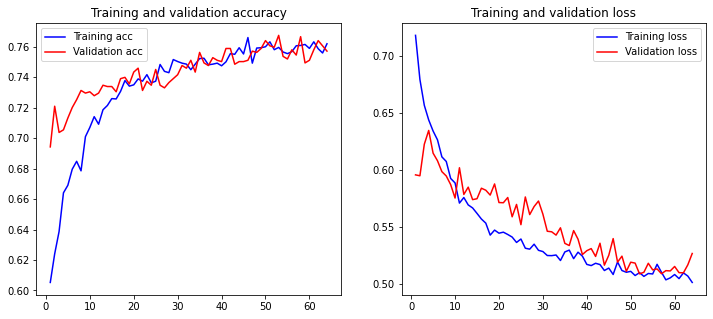

In [8]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

## Feature Extraction and Modulation

In [0]:
### No of reaction to Source ###
no_of_reaction = []
for _ ,tweets in source.iterrows():
    temp_reaction = reaction[reaction["in_reply_to_status_id"] == tweets["id_str"]]
    no = len(list(temp_reaction["id_str"]))
    no_of_reaction.append(no)

In [0]:
no_of_doubt_punt = []
for _,tweets in source.iterrows():
    _treaction = reaction[reaction["in_reply_to_status_id"] == tweets["id_str"]]
    _ttweet = list(_treaction["text"])
    _ttweet = " ".join(_ttweet)
    tweet = tweets["text"] + " " + _ttweet
    words = word_tokenize(tweet)
    _tcount = [1 for i in words if i == '?' or i == '!']
    no_of_doubt_punt.append(len(_tcount))

In [0]:
veri = [0 if i==False else 1 for i in source["user_verified"]]
ufolcount = list(source["user_followers_count"])
ufricount = list(source["user_friends_count"])
favcount = list(source["favorite_count"])
tran = [0 if i==False else 1 for i in source["user_is_translator"]]
rtcount = list(source["retweet_count"])

In [0]:
_fX = [veri,ufolcount,ufricount,favcount,tran,rtcount,no_of_reaction,no_of_doubt_punt]
fX = np.array(_fX).T
fy = [1 if label == "rumours" else 0 for label in source['label']]

In [0]:
### Spliting the data using the same distribution used in text model.
fX_train, fX_test, fy_train, fy_test = train_test_split(fX, fy, test_size = 0.2, random_state = 0)

## Feature Model Training

In [0]:
#### Tweeter Details Model #####

fmodel = Sequential()

fmodel.add(Dense(20, activation='relu', input_dim=8))
fmodel.add(Dense(15, activation='relu'))
fmodel.add(Dense(7, activation='relu'))
fmodel.add(Dense(1, activation='sigmoid'))
fmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#model.summary()

## Training the model
history = fmodel.fit(fX_train, fy_train, epochs=32, batch_size=32,validation_data=(fX_test,fy_test))
loss, accuracy = fmodel.evaluate(fX_train, fy_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = fmodel.evaluate(fX_test, fy_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 4641 samples, validate on 1161 samples
Epoch 1/32
4641/4641 [==============================] - 0s 77us/step - loss: 13999.1918 - accuracy: 0.5354 - val_loss: 352.8393 - val_accuracy: 0.4763
Epoch 2/32
4641/4641 [==============================] - 0s 47us/step - loss: 164.0044 - accuracy: 0.4650 - val_loss: 131.6398 - val_accuracy: 0.4419
Epoch 3/32
4641/4641 [==============================] - 0s 45us/step - loss: 130.7581 - accuracy: 0.5066 - val_loss: 22.0483 - val_accuracy: 0.5099
Epoch 4/32
4641/4641 [==============================] - 0s 47us/step - loss: 121.3365 - accuracy: 0.5904 - val_loss: 68.0736 - val_accuracy: 0.5676
Epoch 5/32
4641/4641 [==============================] - 0s 49us/step - loss: 135.4890 - accuracy: 0.6212 - val_loss: 530.0893 - val_accuracy: 0.6512
Epoch 6/32
4641/4641 [==============================] - 0s 47us/step - loss: 170.9765 - accuracy: 0.6050 - val_loss: 219.6478 - val_accuracy: 0.5108
Epoch 7/32
4641/4641 [==============================] - 0s

## Combining the Results of both the models.

In [0]:
### Converts model output to list
def tolist(output):
    List = []
    for out in output:
        v = list(out)
        List.append(v[0])
    return List

In [10]:
text_out = tolist(list((model_text.predict(train_vecs) > 0.5).astype(int)))
feat_out = tolist(list((fmodel.predict(fX_train) > 0.5).astype(int)))
nX_train = np.array([text_out,feat_out]).T

text_out = tolist(list((model_text.predict(test_vecs) > 0.5).astype(int)))
feat_out = tolist(list((fmodel.predict(fX_test) > 0.5).astype(int)))
nX_test = np.array([text_out,feat_out]).T

nY_train = y_train
nY_test = y_test

NameError: ignored

In [0]:
### Combining Model ###

nmodel = Sequential()
nmodel.add(Dense(10, activation='tanh', input_dim=2))
nmodel.add(Dense(20, activation='sigmoid'))
nmodel.add(Dense(5, activation='sigmoid'))
nmodel.add(Dense(1, activation='sigmoid'))
nmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Training the model
history = nmodel.fit(nX_train, nY_train, epochs=32, batch_size=128,validation_data=(nX_test,nY_test))
loss, accuracy = nmodel.evaluate(nX_train, nY_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = nmodel.evaluate(nX_test, nY_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 4641 samples, validate on 1161 samples
Epoch 1/32
4641/4641 [==============================] - 0s 43us/step - loss: 0.6387 - accuracy: 0.6617 - val_loss: 0.6394 - val_accuracy: 0.6537
Epoch 2/32
4641/4641 [==============================] - 0s 14us/step - loss: 0.6291 - accuracy: 0.6617 - val_loss: 0.6314 - val_accuracy: 0.6537
Epoch 3/32
4641/4641 [==============================] - 0s 14us/step - loss: 0.6186 - accuracy: 0.6617 - val_loss: 0.6206 - val_accuracy: 0.6537
Epoch 4/32
4641/4641 [==============================] - 0s 15us/step - loss: 0.6044 - accuracy: 0.6617 - val_loss: 0.6060 - val_accuracy: 0.6537
Epoch 5/32
4641/4641 [==============================] - 0s 14us/step - loss: 0.5852 - accuracy: 0.6617 - val_loss: 0.5868 - val_accuracy: 0.6537
Epoch 6/32
4641/4641 [==============================] - 0s 18us/step - loss: 0.5621 - accuracy: 0.6617 - val_loss: 0.5665 - val_accuracy: 0.6537
Epoch 7/32
4641/4641 [==============================] - 0s 14us/step - loss: 0.539

This result indicates that rumour have huge depends on the content of the rumour and very little depends on other factors around the rumours such as features that have been consided here. This can be seem from the fact the accuray did not increase any furthur than it did from text model.

## Performance Measure


In [17]:
## Model Output
predicted = tolist(list((model_text.predict(test_vecs) > 0.5).astype(int)))
expected = y_test

## Model Performances
recall = recall_score(expected, predicted, average='macro')
precision = precision_score(expected, predicted, average='macro')
accuracy = accuracy_score(expected, predicted)
f1 = f1_score(expected, predicted, average='macro')
recall = recall_score(expected, predicted, average='macro')

## Printing them out
print("Performance")
print("Accuracy:",accuracy,"\nPrecision:",precision,"\nF1-Score:",f1,"\nRecall:",recall)

Performance
Accuracy: 0.7571059431524548 
Precision: 0.7321023223328095 
F1-Score: 0.7335803843449731 
Recall: 0.7352516075747744


## Live Detection

In [56]:
def Romour_Test(tweet):
    
    ### Creating a word vector
    sents = []
    words = tokenizer.tokenize(tweet)
    words = [lemma.lemmatize(word) for word in words if word not in puntuation and word not in stop_words and "http" not in word and not word.startswith('/')]
    words = list(set(words))
    sents.append(words)

    vecs = np.concatenate([buildWordVector(z, 100) for z in map(lambda x: x, sents)])
    vecs = scale(vecs)
    vecs = vecs.reshape(1,100)

    pred = tolist(list((model_text.predict(vecs) > 0.5).astype(int)))[0]
    if pred == 1:
        print("Romour!")
    else:
        print("Not a Romour!")

print("The Model runs at 75% accuracy!\nNOte: More data related to tweet, better the model works. Lesser the data, the performance decrease.\n")
Romour_Test("The sun rised from north. which is very funny")

The Model runs at 75% accuracy!
NOte: More data related to tweet, better the model works. Lesser the data, the performance decrease.

Romour!


In [53]:
#Sample test Cases
Romour_Test("World will end today.")
Romour_Test("The sun rises from east.")

Romour!
Not a Romour!
